### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

Ваше решение тут:

1) MSE: $- \frac{\partial}{\partial a(x_i)} L(a(x_i), y_i)) = 2 \cdot (y_i - a(x_i))$.

2) Экспоненциальная: $- \frac{\partial}{\partial a(x_i)} L(a(x_i), y_i) = y_i \cdot exp(-a(x_i)y_i)$

3) Логистическая: $- \frac{\partial}{\partial a(x_i)} L(a(x_i), y_i) = \frac{ y_i \cdot exp(-a(x_i)y_i)}{ 1 + exp(-a(x_i)y_i)}$


##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

In [179]:
class MyGradientBoostingClassifier:

    def __init__(self, loss='mse', learning_rate=0.1, n_estimators=100, colsample=0.5, subsample=0.5, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.args = args
        self.kwargs = kwargs
        self.models = []
        self.features = []

    def target(self, y, a):
        if self.loss == 'mse':
            return 2*(y - a)
        elif self.loss == 'log':
            return y*np.exp(- y*a) / (1 + np.exp(-y*a))
        else:
            return y*np.exp(-y*a)

    def __choose_samples(self, a):
        features_indexes = np.random.randint(self.X.shape[1], size = round(self.X.shape[1]*self.colsample))
        self.features.append(features_indexes)
        X_features = self.X[:, features_indexes]
        objects_indexes = np.random.randint(self.X.shape[1], size = round(self.X.shape[1]*self.subsample))
        X_sample = X_features[objects_indexes, :] 
        y_sample = self.y[objects_indexes]
        a_sample = a[objects_indexes] 
        return X_sample, X_features, y_sample, a_sample

    def fit(self, X, y, base_model = DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        self.X = np.array(X)
        self.y = np.array(y)
        if init_model is None:
            a = np.mean(y) * np.ones([y.shape[0]])
        else: 
            model = init_model(*self.args, **self.kwargs)
            model.fit(X, y)
            self.models.append(model)
            self.features.append(list(range(X.shape[1])))
            a = np.array(model.predict(X))
        for estimator in range(self.n_estimators):
            X_sample, X_features, y_sample, a_sample = self.__choose_samples(a)
            model = base_model(*self.args, **self.kwargs)
            model.fit(X_sample, self.target(y_sample, a_sample))
            self.models.append(model)
            prediction = np.asarray(model.predict(X_features))
            a += self.learning_rate*prediction

    def predict(self, X):
        a = np.ones([X.shape[0]]) * np.mean(self.y)
        for t in range(len(self.models)):
            a += self.learning_rate*self.models[t].predict(X[:, self.features[t]])
        return np.round(a)



In [180]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier(random_state=0)

In [181]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target, random_state=0)

In [182]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [6]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [7]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [8]:
accuracy = []
for n_estimators in range(1, 200, 5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    my_clf = MyGradientBoostingClassifier(n_estimators=n_estimators)
    my_clf.fit(X_train, y_train)
    accuracy.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

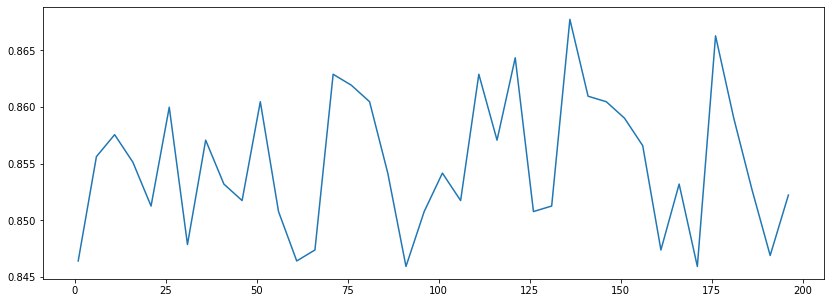

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,5))
plt.plot(range(1, 200, 5), accuracy)
plt.show()

In [10]:
best_n_estimators = np.argmax(accuracy)*5
best_n_estimators

135

In [12]:
params = []
accuracy = []
i = 1
for loss in ['mse', 'exp', 'log']:
    for subsample in [0.25, 0.5, 0.75, 1]:
        for colsample in [0.25, 0.5, 0.75, 1]:
            for learning_rate in [0.1, 0.3, 0.5]:
                my_clf = MyGradientBoostingClassifier(n_estimators=best_n_estimators, loss = loss,
                                                      subsample = subsample, colsample = colsample,
                                                      learning_rate = learning_rate)
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                        stratify=y)
                my_clf.fit(X_train, y_train)
                params.append([loss, subsample, colsample, learning_rate])
                accuracy.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))
print('Best params: ',params[np.argmax(accuracy)], ' with score', np.max(accuracy))

Best params:  ['mse', 1, 0.5, 0.1]  with score 0.877906976744186


## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

my_clf = MyGradientBoostingClassifier(loss = 'mse', learning_rate = 0.1, n_estimators = 135, colsample = 0.5, subsample = 1)
my_clf.fit(X_train, y_train)
print("Best score before:", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

my_clf = MyGradientBoostingClassifier('mse', 0.1, 135, 0.5, 1, 10)
my_clf.fit(X_train, y_train, RandomForestRegressor)
print("Score with random forest as base model:", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

a = np.ones([X_test.shape[0]])*np.mean(y_train)
for i in range(10):
    indices = np.random.randint(0, len(y_train), (1, len(y_train)))[0]
    X_samples = X_train[indices, :]
    y_samples = y_train[indices]
    my_clf = MyGradientBoostingClassifier(loss = 'mse', learning_rate = 0.1, n_estimators = 135, colsample = 0.5, subsample = 1)
    my_clf.fit(X_samples, y_samples, DecisionTreeRegressor)
    a += my_clf.predict(X_test)
a = np.round(a / 10)
print("Score with 10 boosting algorithms:", accuracy_score(y_pred=a, y_true=y_test))

Best score before: 0.8561046511627907
Score with random forest as base model: 0.877422480620155
Score with 10 boosting algorithms: 0.8783914728682171


Оба алгоритма показали прирост результата.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

my_clf = MyGradientBoostingClassifier(loss = 'mse', learning_rate = 0.1, n_estimators = 135, colsample = 0.5, subsample = 1)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model = None)
print("Const init:", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

my_clf = MyGradientBoostingClassifier(loss = 'mse', learning_rate = 0.1, n_estimators = 135, colsample = 0.5, subsample = 1)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=LinearRegression)
print("Linear Regression: ", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

my_clf = MyGradientBoostingClassifier(loss = 'mse', learning_rate = 0.1, n_estimators = 135, colsample = 0.5, subsample = 1)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=RandomForestRegressor)
print("Random Forest: ", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

my_clf = MyGradientBoostingClassifier(loss = 'mse', learning_rate = 0.1, n_estimators = 135, colsample = 0.5, subsample = 1)
my_clf.fit(X_train, y_train, DecisionTreeRegressor, init_model=SVC)
print("SVC: ", accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

Const init: 0.8488372093023255
Linear Regression:  0.7848837209302325
Random Forest:  0.8468992248062015
SVC:  0.8449612403100775


По необъяснимой причине скор не увеличился.

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

